In [64]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

In [47]:
with open('converted_unit.json', 'r') as f:
    experiments = json.load(f)
with open('test.json', 'r') as f:
    simulations = json.load(f)
    
print(len(list(experiments)))
print(len(list(simulations)))

139
139


In [52]:
def get_data_from_json(list1, sim=True):
    if sim == True:
        pressures = []
        uptakes = []
        errors = []
        
        for value in list1:
            if value['pressure'] < 1000:
                continue
            elif value['uptake'] < 0:
                continue
            else:
                pressures.append(value['pressure'])
                uptakes.append(value['uptake'])
                errors.append(value['error'])
        return pressures, uptakes, errors
    else:
        pressures = []
        uptakes = []
        for value in list1:
            if value['pressure'] < 1000:
                continue
            elif value['uptake'] < 0:
                continue
            else:
                pressures.append(value['pressure'])
                uptakes.append(value['uptake'])
        return pressures, uptakes

In [62]:
temperatures = defaultdict(lambda:0)
adsorbates = defaultdict(lambda:0)
adsorbents = defaultdict(lambda:0)

final_simp = []
final_simu = []
final_sime = []

final_expp = []
final_expu = []
final_temp = []
final_adsorbate = []
final_adsorbent = []
for doi in list(simulations):
    if doi not in experiments:
        print('No data experimental data for {}'.format(doi))
        continue
    for iso in list(simulations[doi]):
        sim_data = simulations[doi][iso]
        exp_data = experiments[doi][iso]
        
        temperatures[exp_data['temperature']] += 1
        adsorbates[exp_data['adsorbate']] += 1
        adsorbents[exp_data['adsorbent']] += 1
        exp_iso = exp_data['isotherm_data']
        
        simp, simu, sime = get_data_from_json(sim_data)
        expp, expu = get_data_from_json(exp_iso, sim=False)
        
        compare_expp = []
        compare_expu = []
        compare_simu = []
        compare_simp = []
        compare_sime = []
        
        for scount, sp in enumerate(simp):
            check_match = False
            for ecount, ep in enumerate(expp):
                if abs(sp - ep) < 1:
                    compare_expp.append(ep)
                    compare_expu.append(expu[ecount])
                    compare_simp.append(sp)
                    compare_simu.append(simu[scount])
                    compare_sime.append(sime[scount])
                    check_match = True
                    break
                else:
                    continue
        if len(compare_simp) != len(compare_expp):
            print(iso)
            print(simp, compare_expp)
            
        for i, j, k in zip(compare_simp, compare_simu, compare_sime):
            final_simp.append(i)
            final_simu.append(j)
            final_sime.append(k)
            final_temp.append(exp_data['temperature'])
            final_adsorbate.append(exp_data['adsorbate'])
            final_adsorbent.append(exp_data['adsorbent'])
        for i, j in zip(compare_expp, compare_expu):
            final_expp.append(i)
            final_expu.append(j)
            
        test = [i - j for i, j in zip(compare_simu, compare_expu)]
        relative = [abs(i-j)/j for  i, j in zip(compare_simu, compare_expu)]
        if min(test) < -2000:
            print(iso, min(test))
        if min(relative) < -0:
            print(iso, min(relative), compare_expu[relative.index(min(relative))])

No data experimental data for 10.1039c3cc48275h


In [65]:
compared_data = pd.DataFrame({
    'exp_pressure': final_expp,
    'exp_uptake': final_expu,
    'sim_pressure': final_simp,
    'sim_uptake': final_simu,
    'sim_error': final_sime,
    'temperature': final_temp,
    'adsorbate': final_adsorbate,
    'adsorbent': final_adsorbent
    
})

compared_data

,exp_pressure,exp_uptake,sim_pressure,sim_uptake,sim_error,temperature,adsorbate,adsorbent
0,10014.4,389.656800,10014.0,458.004137,0.901889,77,Nitrogen,LASYOU_clean_DDEC.cif
1,104619.0,420.244800,104619.0,458.199035,1.001565,77,Nitrogen,LASYOU_clean_DDEC.cif
2,28367.4,413.252800,28367.0,452.443373,4.817600,77,Nitrogen,LASYOU_clean_DDEC.cif
3,4770.7,378.295200,4771.0,437.226522,2.473131,77,Nitrogen,LASYOU_clean_DDEC.cif
4,100250.0,285.354788,100250.0,322.972613,6.006559,77,Hydrogen,LASYOU_clean_DDEC.cif
...,...,...,...,...,...,...,...,...
5411,6398080.0,61.975439,6398080.0,58.760988,2.360300,293,Hydrogen,KANMIX_clean_DDEC.cif
5412,695562.0,7.902546,695562.0,7.997123,0.614875,293,Hydrogen,KANMIX_clean_DDEC.cif
5413,7315730.0,71.335720,7315730.0,65.406757,2.285972,293,Hydrogen,KANMIX_clean_DDEC.cif
5414,8386320.0,80.935069,8386320.0,72.688380,1.176200,293,Hydrogen,KANMIX_clean_DDEC.cif


In [76]:
compared_data['uptake_diff'] = compared_data['sim_uptake'] - compared_data['exp_uptake']
compared_data['rel_diff'] = (compared_data['sim_uptake'] - compared_data['exp_uptake'])/compared_data['exp_uptake']
compared_data['abs_rel_diff'] = abs((compared_data['sim_uptake'] - compared_data['exp_uptake']))/compared_data['exp_uptake']
compared_data_lowP = compared_data[compared_data['exp_pressure'] < 120000]

In [78]:
df_ch4 = compared_data_lowP[compared_data_lowP['adsorbate'] == 'Methane']
df_n2 = compared_data_lowP[compared_data_lowP['adsorbate'] == 'Nitrogen']
df_h2 = compared_data_lowP[compared_data_lowP['adsorbate'] == 'Hydrogen']
df_co2 = compared_data_lowP[compared_data_lowP['adsorbate'] == 'Carbon Dioxide']

print('N2: ', df_n2.shape)
print('CO2: ', df_co2.shape)
print('H2: ', df_h2.shape)
print('CH4: ', df_ch4.shape)


N2:  (1118, 11)
CO2:  (1687, 11)
H2:  (934, 11)
CH4:  (608, 11)


Text(0.5, 0, 'Pressure (Pa)')

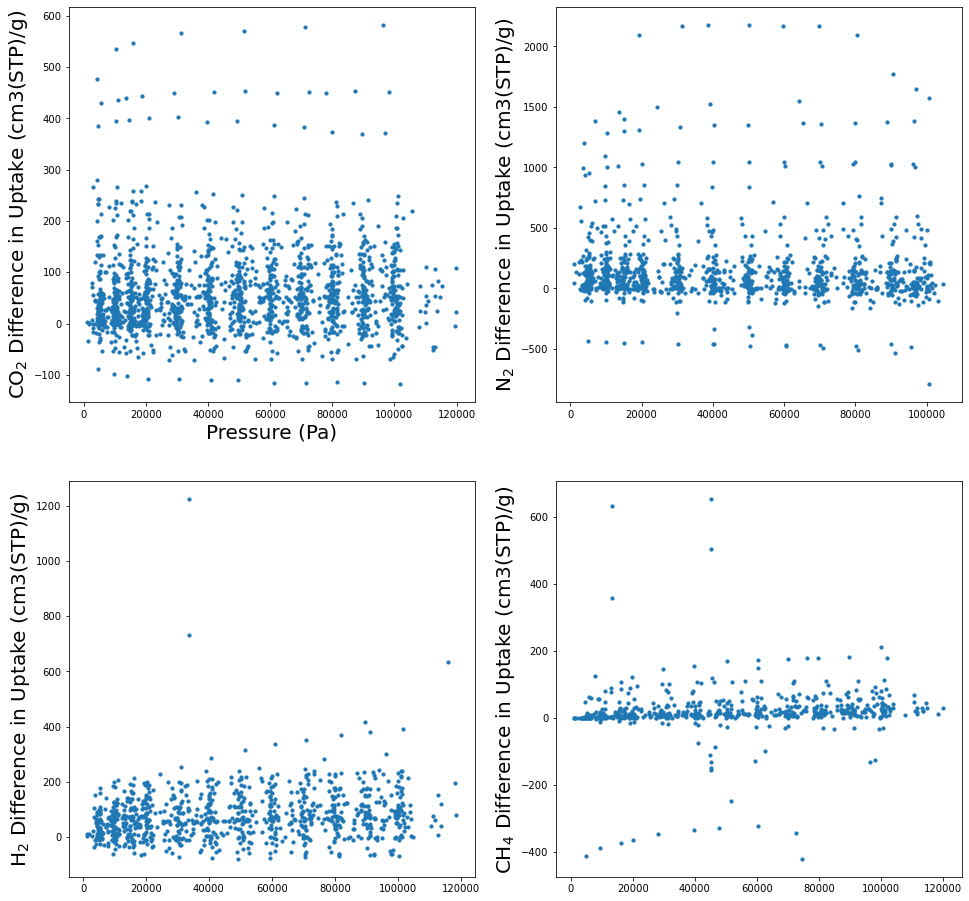

In [92]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16), )
ax[0][0].scatter(df_co2['exp_pressure'], df_co2['uptake_diff'], s=10)
ax[0][1].scatter(df_n2['exp_pressure'], df_n2['uptake_diff'], s=10)
ax[1][0].scatter(df_h2['exp_pressure'], df_h2['uptake_diff'], s=10)
ax[1][1].scatter(df_ch4['exp_pressure'], df_ch4['uptake_diff'], s=10)
ax[0][0].set_ylabel(r'CO$_2$ Difference in Uptake (cm3(STP)/g)', fontsize=20)
ax[0][1].set_ylabel(r'N$_2$ Difference in Uptake (cm3(STP)/g)', fontsize=20)
ax[1][0].set_ylabel(r'H$_2$ Difference in Uptake (cm3(STP)/g)', fontsize=20)
ax[1][1].set_ylabel(r'CH$_4$ Difference in Uptake (cm3(STP)/g)', fontsize=20)

ax[0][0].set_xlabel('Pressure (Pa)', fontsize=20)
ax[0][0].set_xlabel('Pressure (Pa)', fontsize=20)
ax[0][0].set_xlabel('Pressure (Pa)', fontsize=20)
ax[0][0].set_xlabel('Pressure (Pa)', fontsize=20)


(0.0, 50.0)

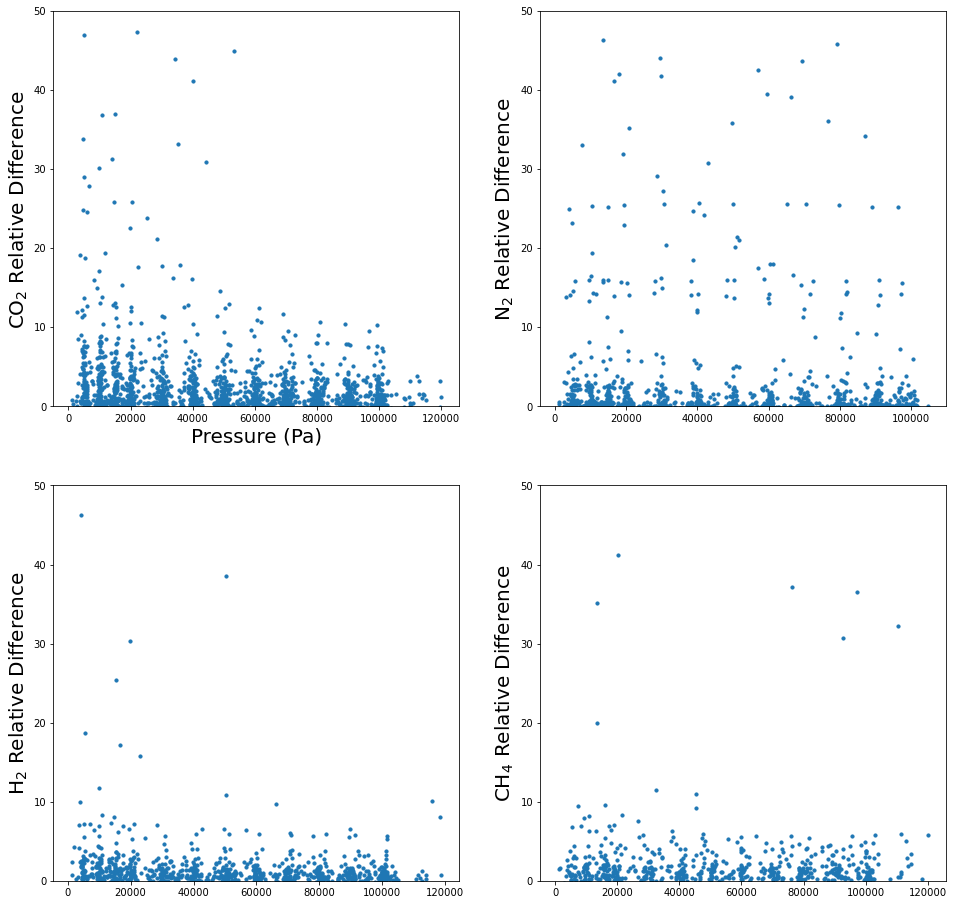

In [97]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16), )
ax[0][0].scatter(df_co2['exp_pressure'], df_co2['rel_diff'], s=10)
ax[0][1].scatter(df_n2['exp_pressure'], df_n2['rel_diff'], s=10)
ax[1][0].scatter(df_h2['exp_pressure'], df_h2['rel_diff'], s=10)
ax[1][1].scatter(df_ch4['exp_pressure'], df_ch4['rel_diff'], s=10)
ax[0][0].set_ylabel(r'CO$_2$ Relative Difference ', fontsize=20)
ax[0][1].set_ylabel(r'N$_2$ Relative Difference ', fontsize=20)
ax[1][0].set_ylabel(r'H$_2$ Relative Difference', fontsize=20)
ax[1][1].set_ylabel(r'CH$_4$ Relative Difference', fontsize=20)

ax[0][0].set_xlabel('Pressure (Pa)', fontsize=20)
ax[0][0].set_xlabel('Pressure (Pa)', fontsize=20)
ax[0][0].set_xlabel('Pressure (Pa)', fontsize=20)
ax[0][0].set_xlabel('Pressure (Pa)', fontsize=20)

ax[0][0].set_ylim(0, 50)
ax[0][1].set_ylim(0, 50)
ax[1][0].set_ylim(0, 50)
ax[1][1].set_ylim(0, 50)

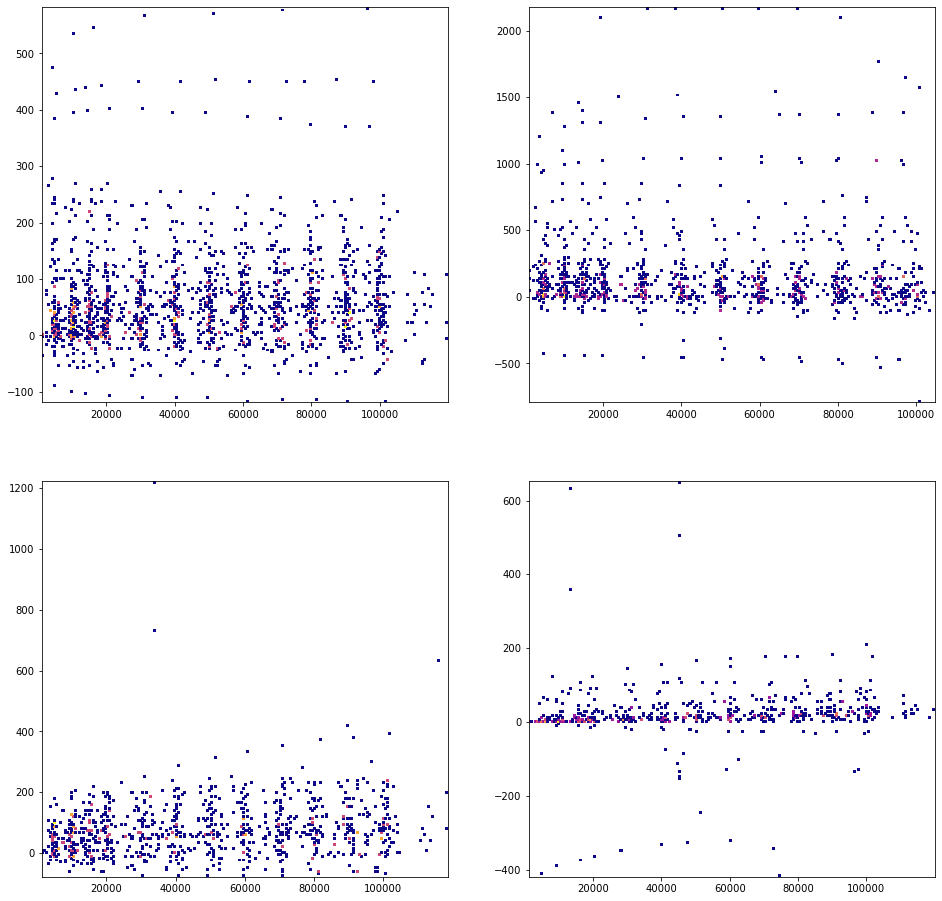

In [89]:
import matplotlib as mpl


fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax[0][0].hist2d(df_co2['exp_pressure'], df_co2['uptake_diff'], bins=200, norm=mpl.colors.LogNorm(), cmin=1, cmap='plasma')
ax[0][1].hist2d(df_n2['exp_pressure'], df_n2['uptake_diff'], bins=200, norm=mpl.colors.LogNorm(), cmin=1, cmap='plasma')
ax[1][0].hist2d(df_h2['exp_pressure'], df_h2['uptake_diff'], bins=200, norm=mpl.colors.LogNorm(), cmin=1, cmap='plasma')
ax[1][1].hist2d(df_ch4['exp_pressure'], df_ch4['uptake_diff'], bins=200, norm=mpl.colors.LogNorm(), cmin=1, cmap='plasma')

ax[0][0].set_
plt.show()

(0.0, 100.0)

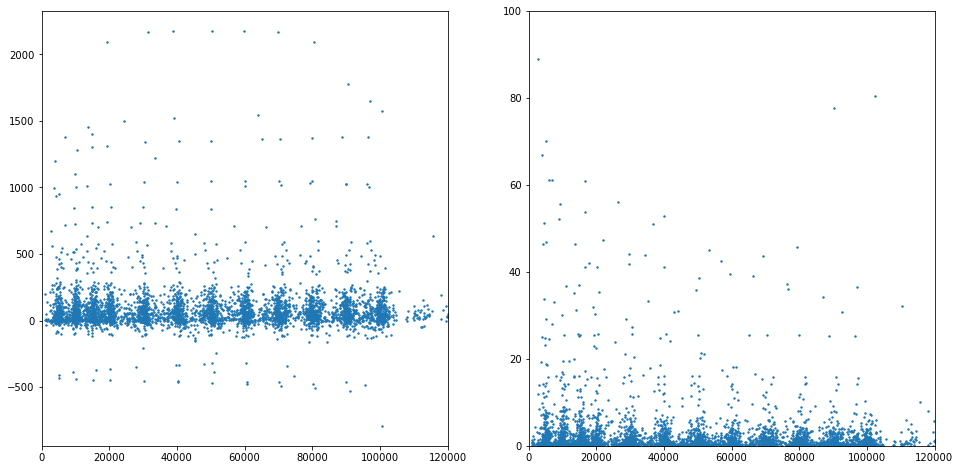

In [55]:
uptake_diff = [i - j for i, j in zip(final_simu, final_expu)]
uptake_diff_rel = [abs(i - j)/j for i, j in zip(final_simu, final_expu)]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(final_simp, uptake_diff, s=2)
#ax.set_ylim(-10000, 10000)
ax[0].set_xlim(0, 120000)

ax[1].scatter(final_simp, uptake_diff_rel, s=2)
#ax.set_ylim(-10000, 10000)
ax[1].set_xlim(0, 120000)

ax[1].set_ylim(0, 100)


(0.0, 100.0)

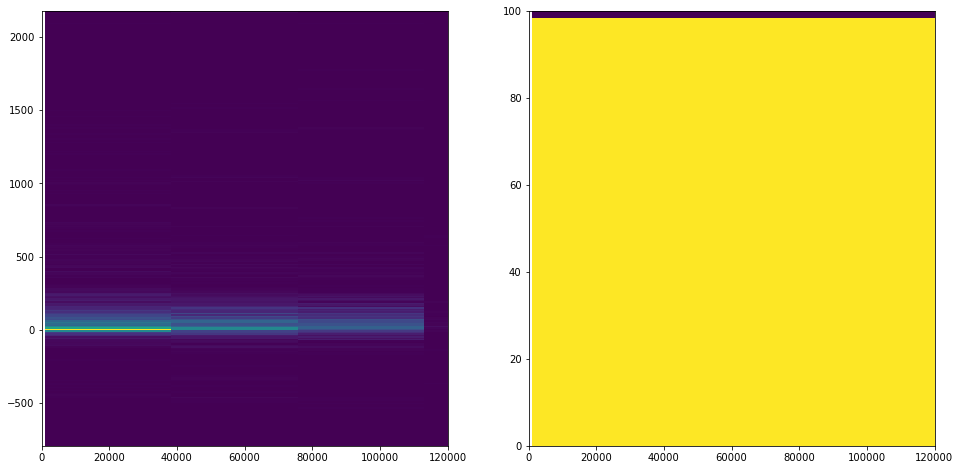

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].hist2d(final_simp, uptake_diff, bins=300)
#ax.set_ylim(-10000, 10000)
ax[0].set_xlim(0, 120000)

ax[1].hist2d(final_simp, uptake_diff_rel)
#ax.set_ylim(-10000, 10000)
ax[1].set_xlim(0, 120000)

ax[1].set_ylim(0, 100)


(0.0, 200.0)

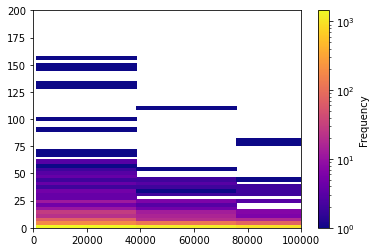

In [61]:
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
im = ax.hist2d(final_simp, uptake_diff_rel, (300, 300), norm=mpl.colors.LogNorm(), cmin=1, cmap='plasma')
cbar = plt.colorbar(im[3], ax=ax)
cbar.set_label('Frequency')
ax.set_xlim(0, 100000)
ax.set_ylim(0, 200)